# Suggest-Evaluate-Register Paradigm with Bayesian Optimization
This is adapted to mannual experiment evaluation process, without a close-form black box function (the experiment is the black box).

Follow the process to find the next parameter for experiment
### Adjustment can be updated:
- Initial data fitting: Gaussian Process Model
- Utility function: ubs, ei, poi
- Based on a two input setup --> for more than two parameters, plot seperate plots to visualize the relationship 


In [140]:
from bayes_opt import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

In [141]:
import logging

# Configure logging
logging.basicConfig(filename='bayesian_optimization.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# # Function to log a message
# def log_experiment(params, result):
#     logging.info(f"Experiment with params {params} yielded result {result}")

def log_experiment(params, result=None):
    if result is not None:
        logging.info(f"Experiment conducted with params {params} yielded result {result}")
    else:
        logging.info(f"Suggestion made with params {params} without result yet")

In [142]:
global best_target

In [143]:
def update_and_log_experiment(suggestion, result):
    best_target = None
    if best_target is None or (result > best_target):  # Assuming maximization problem
        delta = result - best_target if best_target is not None else result
        best_target = result
    else:
        delta = 0  # No improvement
    
    log_experiment(suggestion, result, delta)
    return delta

In [144]:
def is_duplicate(params, optimizer):
    for existing in optimizer.space:
        if existing.params == params:
            return True
    return False

## Step 1: Setup Bayesian Optmization Framework

In [145]:
# Parameter bounds
pbounds = {
    'x': (0, 10),
    'y': (0, 10)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=None,  # f is None because we don't have a black box function
    pbounds=pbounds,
    verbose=2,
    random_state=1
    #allow_duplicate_points=True
)

In [146]:
# Unitiy funciton can be defined 
# Exploitation vs. Exploration: http://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
# Upper confidence bound "ucb" kappa = 0.1 (peak) --> 10 (spread); 
# Expected improvement "ei" xi = 0 (peak) --> 1 (spread);
# Probability of improvement "poi" xi = 1e-4 (peak) --> 0.1 (spread) 

from bayes_opt import UtilityFunction
utility = UtilityFunction(kind="ei", kappa=2.5, xi=1)


## Step 2: Collect and Register Initial Data

In [147]:
# Example initial data (you should replace this with your actual data)
initial_data = [
    {'params': {'x': 1, 'y': 1}, 'target': 3},
    {'params': {'x': 2, 'y': 2}, 'target': 2},
    {'params': {'x': 3, 'y': 3}, 'target': 0.5}
]

for data in initial_data:
    optimizer.register(params=data['params'], target=data['target'])
    log_experiment(data['params'], data['target'])

In [148]:
print(optimizer.res)

[{'target': 3.0, 'params': {'x': 1.0, 'y': 1.0}}, {'target': 2.0, 'params': {'x': 2.0, 'y': 2.0}}, {'target': 0.5, 'params': {'x': 3.0, 'y': 3.0}}]


## Step 3: Suggest and Update

### 3.1. Single next point

In [149]:
# suggest is a funciton can be called anytime
next_point = optimizer.suggest(utility)
print("Next point to probe is:", next_point)
log_experiment(next_point)

Next point to probe is: {'x': 0.0, 'y': 0.0}


In [150]:
# Calculate target value from experiment
experiment_result = 1.5

In [151]:
# When registering new experiment data
optimizer.register(params=next_point, target=experiment_result)
log_experiment(next_point, experiment_result)
#delta = update_and_log_experiment(next_point, experiment_result)

### 3.2. Batch next point

In [102]:
batch_size = 5

In [109]:
# Generate suggestions and manually handle batch testing
suggestions = [optimizer.suggest(utility) for _ in range(batch_size)]

In [110]:
suggestions

[{'x': 0.3850294356437829, 'y': 1.929154192067508},
 {'x': 0.3848470665838382, 'y': 1.9287560184773058},
 {'x': 0.35272266730986157, 'y': 1.8987246241735645},
 {'x': 0.37840910650833615, 'y': 1.9163436460261163},
 {'x': 0.3845283064663576, 'y': 1.928804398546593}]

In [111]:
# Manual input of results for each experiment
results = [0.7, 2.5, 3, 0.88, 1.23]  # Example results from experiments

In [112]:
#results = [run_experiment(s) for s in suggestions]  # Assume this function runs the actual experiment
for suggestion, result in zip(suggestions, results):
    optimizer.register(params=suggestion, target=result)

# After each batch, you can continue to refine and suggest new batches
# This ensures the optimizer's model builds progressively without temporary data issues.

In [113]:
optimizer.res

[{'target': 3.0, 'params': {'x': 1.0, 'y': 1.0}},
 {'target': 2.0, 'params': {'x': 2.0, 'y': 2.0}},
 {'target': 0.5, 'params': {'x': 3.0, 'y': 3.0}},
 {'target': 1.5, 'params': {'x': 0.0, 'y': 0.0}},
 {'target': 0.3, 'params': {'x': 8.300019078873172, 'y': 6.601379171587518}},
 {'target': 0.5, 'params': {'x': 1.4930671317372957, 'y': 6.288117640027626}},
 {'target': 0.8, 'params': {'x': 0.8607209803110327, 'y': 7.586913375625651}},
 {'target': 0.9, 'params': {'x': 3.956274121597614, 'y': 1.6145817185462041}},
 {'target': 1.0, 'params': {'x': 8.876970310565088, 'y': 4.472002496129709}},
 {'target': 0.7, 'params': {'x': 0.3850294356437829, 'y': 1.929154192067508}},
 {'target': 2.5, 'params': {'x': 0.3848470665838382, 'y': 1.9287560184773058}},
 {'target': 3.0,
  'params': {'x': 0.35272266730986157, 'y': 1.8987246241735645}},
 {'target': 0.88,
  'params': {'x': 0.37840910650833615, 'y': 1.9163436460261163}},
 {'target': 1.23, 'params': {'x': 0.3845283064663576, 'y': 1.928804398546593}}]

## Step 3: Function to Plot Response Surface

In [25]:
def plot_response_surface(optimizer):
    # Create a mesh grid of x and y values
    x = np.linspace(pbounds['x'][0], pbounds['x'][1], 100)
    y = np.linspace(pbounds['y'][0], pbounds['y'][1], 100)
    X, Y = np.meshgrid(x, y)
    # Flatten the grid to pass to the optimizer's model
    X_flat = X.ravel()
    Y_flat = Y.ravel()
    # Predict using the surrogate model
    mu, _ = optimizer._gp.predict(np.vstack((X_flat, Y_flat)).T, return_std=True)
    mu = mu.reshape(X.shape)
    
    # Plot
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X, Y, mu, 100)
    plt.colorbar(contour)
    plt.title('Response Surface')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

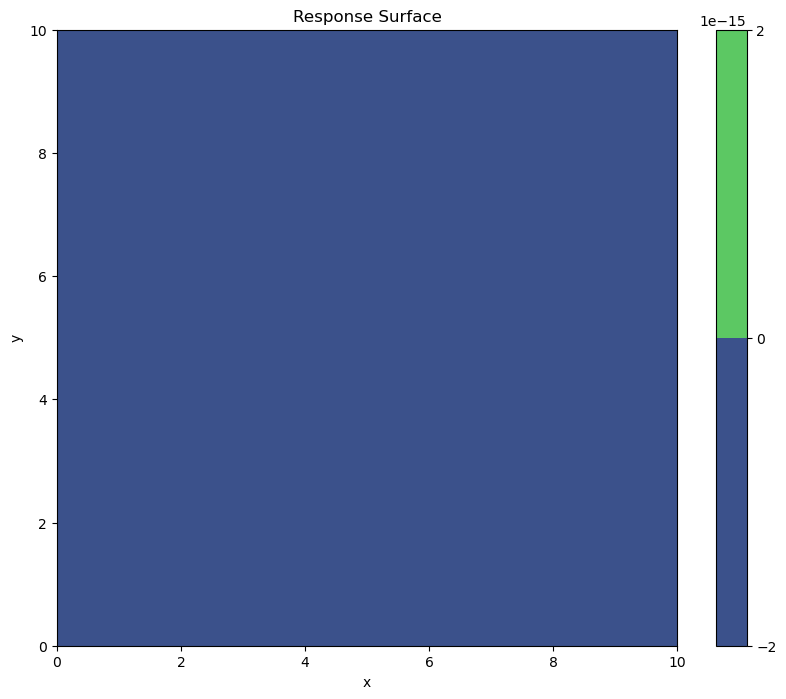

In [26]:
plot_response_surface(optimizer)

## Step 4: Interactive Experiment Loop (suggest next experiment)

In [20]:
# Create a text input widget for entering the experiment results
result_input = widgets.FloatText(
    value=0.0,
    description='Result:',
    disabled=False
)

# Create a button to submit the result and update the optimization
submit_button = widgets.Button(description="Submit Result")

# Output widget to update the plots and text dynamically
output = widgets.Output()

In [21]:
def on_submit_clicked(b):
    # Update the optimizer with the new result
    optimizer.register(params=next_point, target=result_input.value)
    
    # Clear the previous output and display the updated plot
    with output:
        output.clear_output(wait=True)
        print(f"Updated with result: {result_input.value} at point: {next_point}")
        plot_response_surface(optimizer)
        display(result_input, submit_button)  # Display input and button again for next input

# Link the button to the update function
submit_button.on_click(on_submit_clicked)

In [22]:
# Utility function to initialize or reset the experiment suggestion
def start_experiment():
    global next_point  # Declare as global if it's being modified outside this scope
    next_point = optimizer.suggest(utility)
    with output:
        output.clear_output(wait=True)
        print(f"Suggested next point: {next_point}")
        display(result_input, submit_button)

# Display the initial setup
start_experiment()
display(output)

Output()